In [ ]:
# @title ## 1. Imports and Setup
# Import necessary libraries
from platform import python_version
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

print(f"Python Version: {python_version()}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

# Check for CUDA availability
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
if use_cuda:
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) # if using multi-GPU
    # Ensure deterministic behavior for cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

np.random.seed(42)

Python Version: 3.12.12
PyTorch Version: 2.8.0+cu126
Torchvision Version: 0.23.0+cu126
Using device: cuda


In [ ]:
# @title ## 2. Configuration Parameters
#@markdown Use the sliders and dropdowns to configure the model and training:
learning_rate = 0.01 #@param {type:"number", format:"raw"}
activation_choice = 'Tanh' #@param ["ReLU", "Tanh", "ELU", "Sigmoid"]
use_dropout = False #@param {type:"boolean"}
dropout_p = 0.3 #@param {type:"slider", min:0.0, max:0.9, step:0.1}
epochs = 30 #@param {type:"slider", min:1, max:50, step:1}
batch_size = 32 #@param {type:"integer"}
test_sample_count = 10 #@param {type:"slider", min:5, max:100, step:5}

# Determine dropout rate based on checkbox
actual_dropout_p = dropout_p if use_dropout else 0.0

--- Sample Data ---


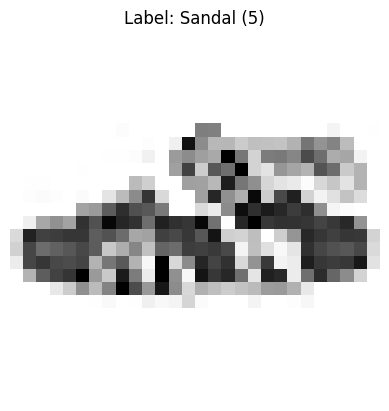

Input data batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])
--------------------


In [ ]:
# @title ## 3. Data Loading and Preprocessing
# Define transformations
transform = transforms.ToTensor()

# Load FashionMNIST dataset
try:
    train_set = torchvision.datasets.FashionMNIST(
        root=".",
        train=True,
        download=True,
        transform=transform
    )
    test_set = torchvision.datasets.FashionMNIST(
        root=".",
        train=False,
        download=True,
        transform=transform
    )
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Please check your internet connection or try manually downloading the dataset.")
    # You might want to exit or raise the exception here depending on desired behavior
    raise e


# Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2 if use_cuda else 0 # Use workers for faster loading if GPU is available
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2 if use_cuda else 0
)

# Define class names
clothing_items = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# --- Visualize a sample ---
print("--- Sample Data ---")
try:
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    # Display one image
    img_index = 0
    plt.imshow(images[img_index].numpy().squeeze(), cmap='gray_r')
    plt.title(f"Label: {clothing_items[labels[img_index]]} ({labels[img_index]})")
    plt.axis('off')
    plt.show()

    print(f"Input data batch shape: {images.size()}")
    print(f"Labels batch shape: {labels.size()}")
except StopIteration:
    print("Could not get a batch from the train_loader. Is the dataset empty?")
except Exception as e:
    print(f"An error occurred during sample visualization: {e}")
print("-" * 20)

In [ ]:
# @title ## 4. Model Definition (CNN)

class Q2CNN(nn.Module):
    def __init__(self, activation_fn, dropout_rate=0.0):
        """
        Initializes the CNN model.

        Args:
            activation_fn: An instance of a PyTorch activation function module (e.g., nn.ReLU()).
            dropout_rate (float): The dropout probability. If 0, no dropout layer is added.
        """
        super(Q2CNN, self).__init__()

        # --- Convolutional Layers ---
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), # Added padding to maintain size
            activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), # Added padding
            activation_fn,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # --- Fully Connected Layers ---
        # Calculate the input size for the linear layer automatically
        # Input image is 28x28. After Conv1+Pool1 -> 14x14. After Conv2+Pool2 -> 7x7.
        # Output channels from Conv2 is 64. So, flattened size is 64 * 7 * 7 = 3136
        fc_layers = [
            nn.Linear(64 * 7 * 7, 1024),
            activation_fn,
            nn.Linear(1024, 256),
            activation_fn,
        ]
        # Add dropout if rate > 0
        if dropout_rate > 0:
            fc_layers.append(nn.Dropout(dropout_rate))

        fc_layers.append(nn.Linear(256, 10)) # Output layer for 10 classes

        self.fc_model = nn.Sequential(*fc_layers) # Unpack the list into Sequential

    def forward(self, x):
        """ Defines the forward pass of the model. """
        x = self.cnn_model(x)     # Pass input through CNN layers
        x = x.view(x.size(0), -1) # Flatten the output for the fully connected layers
        x = self.fc_model(x)      # Pass input through fully connected layers
        return x

In [ ]:
# @title ## 5. Helper Functions (Evaluation, Weight Initialization)

def evaluation(dataloader, model, device):
    """ Evaluates the model accuracy on the given dataloader. """
    total, correct = 0, 0
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for evaluation
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    return 100 * correct / total

def weights_init(m):
    """ Initializes weights of Linear and Conv2d layers using Xavier Uniform. """
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
             torch.nn.init.zeros_(m.bias) # Also initialize bias to zero

In [ ]:
# @title ## 6. Training Setup
# --- Map activation function choice ---
if activation_choice == 'ReLU':
    act_func_instance = nn.ReLU()
elif activation_choice == 'Tanh':
    act_func_instance = nn.Tanh()
elif activation_choice == 'ELU':
    act_func_instance = nn.ELU()
elif activation_choice == 'Sigmoid':
    act_func_instance = nn.Sigmoid()
else:
    print(f"Warning: Unknown activation '{activation_choice}'. Defaulting to ReLU.")
    act_func_instance = nn.ReLU()

print(f"Using Activation: {activation_choice}")
print(f"Using Dropout: {use_dropout}, Rate: {actual_dropout_p if use_dropout else 'N/A'}")
print(f"Learning Rate: {learning_rate}")
print(f"Epochs: {epochs}")
print(f"Batch Size: {batch_size}")

# --- Initialize Model, Loss, Optimizer ---
net = Q2CNN(activation_fn=act_func_instance, dropout_rate=actual_dropout_p).to(device)

# Initialize weights
net.apply(weights_init)

# Define loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Define optimizer
opt = torch.optim.SGD(net.parameters(), lr=learning_rate)

# --- Lists for tracking ---
loss_epoch_array = []
train_accuracy = []
test_accuracy = []

Using Activation: ReLU
Using Dropout: True, Rate: 0.3
Learning Rate: 0.01
Epochs: 30
Batch Size: 32


In [ ]:
# @title ## 7. Training Loop

print("--- Starting Training ---")
for epoch in range(epochs):
    net.train() # Set model to training mode
    loss_epoch = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for i, data in enumerate(progress_bar):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad() # Zero gradients
        outputs = net(inputs) # Forward pass
        loss = loss_fn(outputs, labels) # Calculate loss
        loss.backward() # Backward pass
        opt.step() # Update weights

        loss_epoch += loss.item()

        # Update progress bar description
        progress_bar.set_postfix({'loss': loss.item()})

    # --- Evaluation after each epoch ---
    current_train_acc = evaluation(train_loader, net, device)
    current_test_acc = evaluation(test_loader, net, device)

    loss_epoch_array.append(loss_epoch / len(train_loader)) # Store average loss
    train_accuracy.append(current_train_acc)
    test_accuracy.append(current_test_acc)

    print(f"Epoch {epoch + 1}: Avg Loss: {loss_epoch_array[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}%, Test Acc: {test_accuracy[-1]:.2f}%")

print("--- Training Finished ---")

--- Starting Training ---


Epoch 1/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 1: Avg Loss: 0.7820, Train Acc: 82.30%, Test Acc: 81.21%


Epoch 2/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 2: Avg Loss: 0.4866, Train Acc: 85.55%, Test Acc: 84.55%


Epoch 3/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 3: Avg Loss: 0.4207, Train Acc: 85.43%, Test Acc: 84.30%


Epoch 4/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 4: Avg Loss: 0.3828, Train Acc: 87.15%, Test Acc: 86.02%


Epoch 5/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 5: Avg Loss: 0.3554, Train Acc: 87.45%, Test Acc: 85.94%


Epoch 6/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 6: Avg Loss: 0.3346, Train Acc: 88.91%, Test Acc: 87.66%


Epoch 7/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 7: Avg Loss: 0.3165, Train Acc: 89.35%, Test Acc: 87.95%


Epoch 8/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 8: Avg Loss: 0.3028, Train Acc: 90.13%, Test Acc: 88.74%


Epoch 9/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 9: Avg Loss: 0.2899, Train Acc: 89.83%, Test Acc: 88.06%


Epoch 10/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 10: Avg Loss: 0.2784, Train Acc: 90.76%, Test Acc: 89.08%


Epoch 11/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 11: Avg Loss: 0.2672, Train Acc: 91.09%, Test Acc: 89.26%


Epoch 12/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 12: Avg Loss: 0.2590, Train Acc: 90.72%, Test Acc: 89.18%


Epoch 13/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 13: Avg Loss: 0.2522, Train Acc: 92.07%, Test Acc: 90.11%


Epoch 14/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 14: Avg Loss: 0.2424, Train Acc: 91.42%, Test Acc: 89.56%


Epoch 15/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 15: Avg Loss: 0.2349, Train Acc: 91.95%, Test Acc: 89.96%


Epoch 16/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 16: Avg Loss: 0.2285, Train Acc: 92.61%, Test Acc: 90.39%


Epoch 17/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 17: Avg Loss: 0.2215, Train Acc: 92.52%, Test Acc: 90.14%


Epoch 18/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 18: Avg Loss: 0.2159, Train Acc: 92.89%, Test Acc: 90.41%


Epoch 19/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 19: Avg Loss: 0.2090, Train Acc: 93.13%, Test Acc: 90.42%


Epoch 20/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 20: Avg Loss: 0.2031, Train Acc: 93.57%, Test Acc: 90.84%


Epoch 21/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 21: Avg Loss: 0.1956, Train Acc: 93.64%, Test Acc: 90.71%


Epoch 22/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 22: Avg Loss: 0.1901, Train Acc: 93.68%, Test Acc: 90.66%


Epoch 23/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 23: Avg Loss: 0.1841, Train Acc: 94.26%, Test Acc: 90.99%


Epoch 24/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 24: Avg Loss: 0.1792, Train Acc: 94.17%, Test Acc: 90.97%


Epoch 25/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 25: Avg Loss: 0.1732, Train Acc: 94.63%, Test Acc: 91.38%


Epoch 26/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 26: Avg Loss: 0.1677, Train Acc: 94.74%, Test Acc: 91.44%


Epoch 27/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 27: Avg Loss: 0.1623, Train Acc: 94.71%, Test Acc: 91.28%


Epoch 28/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 28: Avg Loss: 0.1585, Train Acc: 95.01%, Test Acc: 91.32%


Epoch 29/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 29: Avg Loss: 0.1535, Train Acc: 95.15%, Test Acc: 91.29%


Epoch 30/30:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch 30: Avg Loss: 0.1484, Train Acc: 95.50%, Test Acc: 91.64%
--- Training Finished ---


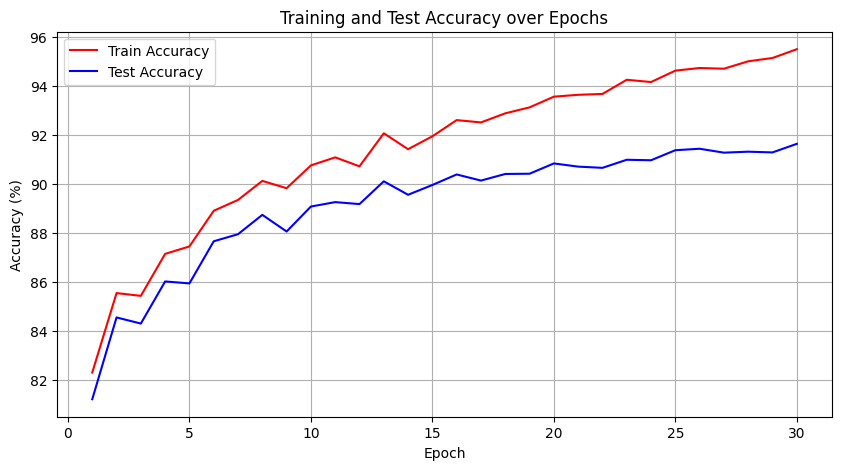

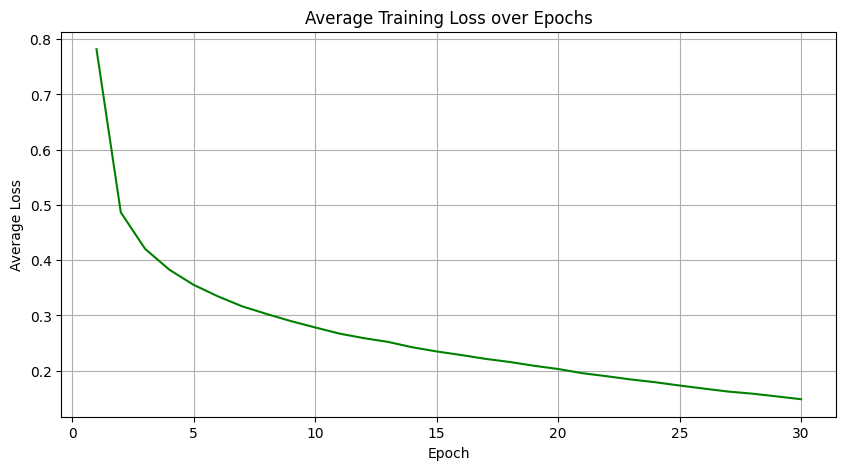


Final Training Accuracy: 95.50%
Final Test Accuracy: 91.64%


In [ ]:
# @title ## 8. Evaluation and Visualization

# --- Plot Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracy, 'r-', label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy, 'b-', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Loss ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_epoch_array, 'g-')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Training Loss over Epochs")
plt.grid(True)
plt.show()

print(f"\nFinal Training Accuracy: {train_accuracy[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracy[-1]:.2f}%")

In [ ]:
# @title ## 9. Save Model Weights
model_save_path = 'fashion_mnist_cnn_model.pth'
torch.save(net.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to fashion_mnist_cnn_model.pth



--- Visualizing 10 Random Test Samples ---
Model weights loaded successfully.


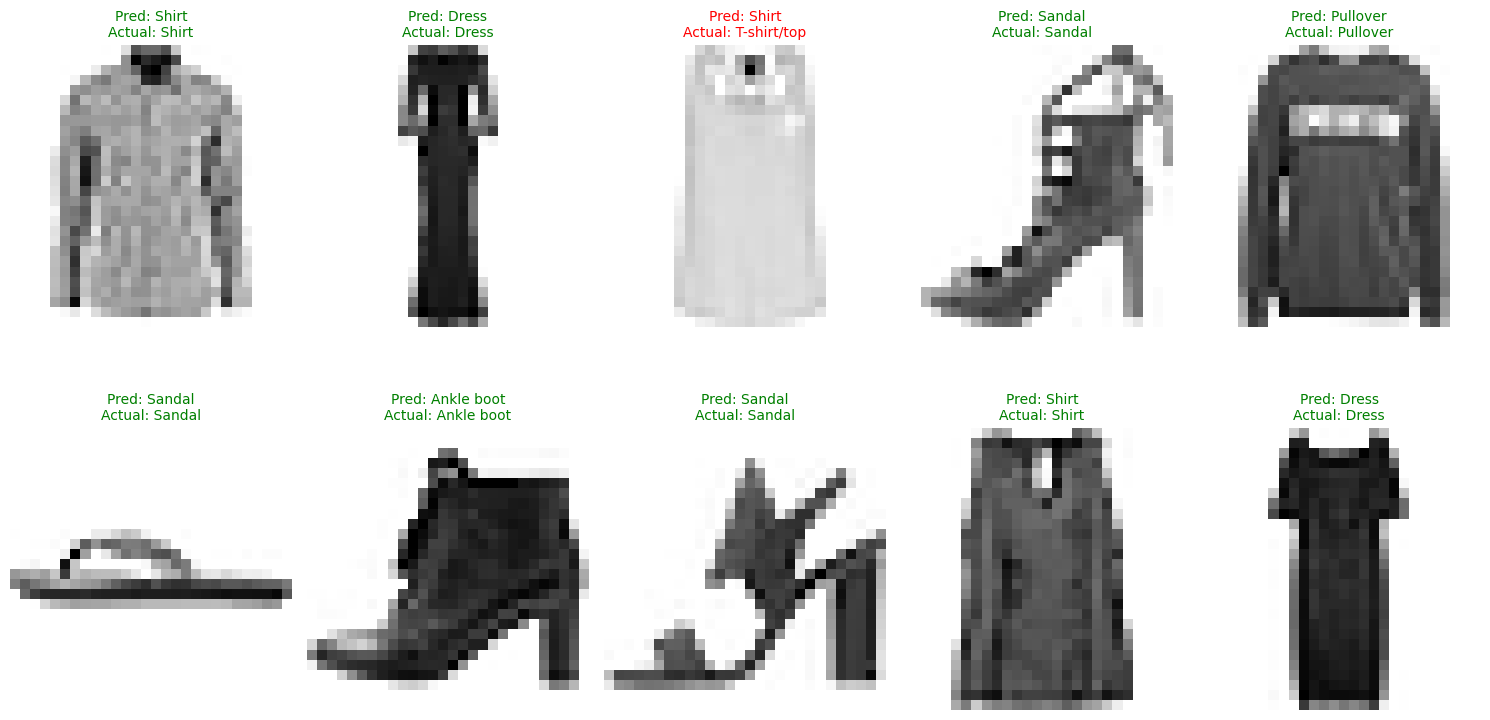


Results for the 10 samples shown:
Correct predictions: 9
Wrong predictions: 1
Accuracy on this sample: 90.00%


In [ ]:
# @title ## 10. Load Model and Visualize Predictions

print(f"\n--- Visualizing {test_sample_count} Random Test Samples ---")

# --- Load the saved model ---
# Create a new instance of the model with the SAME architecture
# Ensure act_func_instance and actual_dropout_p are accessible from cell 6
# Or re-define them based on the saved configuration if necessary
loaded_net = Q2CNN(activation_fn=act_func_instance, dropout_rate=actual_dropout_p).to(device)
try:
    loaded_net.load_state_dict(torch.load(model_save_path, map_location=device))
    loaded_net.eval()  # Set the model to evaluation mode
    print("Model weights loaded successfully.")

    # --- Get random samples from the test set ---
    test_images = test_set.data
    test_labels = test_set.targets

    if len(test_images) >= test_sample_count:
        random_indices = np.random.choice(len(test_images), test_sample_count, replace=False)

        # Select the random images and labels, unsqueeze, normalize, and move to device
        images = test_images[random_indices].unsqueeze(1).float() / 255.0
        labels = test_labels[random_indices]
        images = images.to(device) # Move images to the correct device for inference

        # --- Classify the selected images ---
        correct_count = 0
        wrong_count = 0
        with torch.no_grad():
            outputs = loaded_net(images)
            _, predicted = torch.max(outputs.data, 1)

            # Move results back to CPU for numpy/matplotlib
            images_cpu = images.cpu()
            predicted_cpu = predicted.cpu()
            labels_cpu = labels # Labels are already tensors, assume CPU unless specified

            # --- Display the images, predictions, and actual labels ---
            plt.figure(figsize=(15, 4 * (test_sample_count // 5 + 1))) # Adjust figure size based on count
            for i in range(test_sample_count):
                plt.subplot(test_sample_count // 5 + 1, 5, i + 1) # Arrange in rows of 5
                plt.imshow(images_cpu[i].squeeze().numpy(), cmap="gray_r")
                pred_label = clothing_items[predicted_cpu[i].item()]
                actual_label = clothing_items[labels_cpu[i].item()]
                is_correct = predicted_cpu[i].item() == labels_cpu[i].item()
                if is_correct:
                    correct_count += 1
                    title_color = 'green'
                else:
                    wrong_count += 1
                    title_color = 'red'

                plt.title(f"Pred: {pred_label}\nActual: {actual_label}", color=title_color, fontsize=10)
                plt.axis('off')

            plt.tight_layout()
            plt.show()

        print(f"\nResults for the {test_sample_count} samples shown:")
        print(f"Correct predictions: {correct_count}")
        print(f"Wrong predictions: {wrong_count}")
        print(f"Accuracy on this sample: {100 * correct_count / test_sample_count:.2f}%")
    else:
        print(f"Requested sample count ({test_sample_count}) is larger than the test set size ({len(test_images)}).")

except FileNotFoundError:
    print(f"Error: Model weights file not found at {model_save_path}. Please train and save the model first.")
except Exception as e:
    print(f"An error occurred during model loading or prediction visualization: {e}")

In [ ]:
# @title ## 11. Download Model File (Optional - Colab Specific)
#@markdown Check the box below and run the cell to download the saved model weights file.
download_file = False #@param {type:"boolean"}

if download_file:
    try:
        from google.colab import files
        files.download(model_save_path)
        print("Download initiated.")
    except ImportError:
        print("Not running in Google Colab. File download via 'google.colab.files' is not available.")
    except Exception as e:
        print(f"An error occurred during file download: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated.
